In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import requests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import os

from sources.esgrating import ESGratings
from sources.famafrench import FamaFrench
from sources.optimizer import Optimizer 
from sources.plotter import Plotter

plotter = Plotter()
optimizer = Optimizer()
ESG = ESGratings()

rf_rate = 0.048 
FF = FamaFrench(rf_rate = rf_rate)

# General Settings: 
days_in_year = 250

In [4]:
# data: 
file_location = r'D:\studie\main_studie\files\asset_pricing\assignments_assetpricing\trading_game\data\week5\trading-game-data-28112023.xlsx'

# Trading game Data:
xls_dict  = pd.read_excel(file_location, sheet_name=None)

for key, df in xls_dict.items():
    if 'KVUE' in df.columns and 'VLTO' in df.columns:
        xls_dict[key] = df.drop(['KVUE', 'VLTO', 'ATVI'], axis=1)

info_df = xls_dict['info'][['Ticker', 'RBICS Economy']]
info_df = info_df.set_index('Ticker')

index_price_df = xls_dict['index-price']
index_price_df['Date'] = pd.to_datetime(index_price_df['Date'])
index_price_df.set_index('Date', inplace=True)

price_df = xls_dict['price'].reset_index()
price_df = price_df.drop('index', axis = 1)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)
# price_df = price_df.drop(['VLTO','KVUE'], axis = 1)

size_df = xls_dict['size']
price_to_book_df = xls_dict['price-to-book']

turnover_df = xls_dict['turnover']
turnover_df['Date'] = pd.to_datetime(turnover_df['Date'])
turnover_df.set_index('Date', inplace=True)

volume_df = turnover_df/price_df

In [5]:
# LOG return: 
def calcualte_logreturns(price_df):
    # Assuming price_df is indexed by date and contains end-of-day prices
    daily_returns = np.log(price_df / price_df.shift(1))
    return daily_returns

daily_logreturns = calcualte_logreturns(price_df).dropna()
monthly_logreturns = calcualte_logreturns(price_df.asfreq('M', method='ffill')).dropna()
anual_logreturns = daily_logreturns * days_in_year #set at 250

daily_SP500_logreturns = calcualte_logreturns(index_price_df['S&P 500']).dropna()
monthly_SP500_logreturns = calcualte_logreturns(index_price_df['S&P 500'].asfreq('M', method='ffill')).dropna()
annual_sp500_logreturns = daily_SP500_logreturns * days_in_year #set at 250

In [6]:
# reading momentum + 5 factors + tansform:
momentum_df = pd.read_csv('data/' + 'F-F_Momentum_Factor_daily.CSV', )
factors_df = pd.read_csv('data/' + 'F-F_5factors_daily.CSV')

momentum_df.columns = ['Date', 'Momentum']
factors_df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factors_df = factors_df.merge(momentum_df, on='Date')
factors_df = factors_df.rename(columns={"Unnamed: 0": "Date"})
factors_df['Date'] = pd.to_datetime(factors_df['Date'], format='%Y%m%d')
factors_df.set_index('Date', inplace=True)

if os.path.isfile('data/ForecastedFF_VAR.par'):
    forecasted_df = pd.read_parquet('data/ForecastedFF_VAR.par')
else:
    forecasted_df = FF.forecast_VAR_ff(factors_df, daily_logreturns)
# forecasted_df['Market_Risk_Premium'] = daily_SP500_logreturns.subtract(rf_rate)

iml_factor = FF.calc_iml_factor(daily_logreturns, volume_df, nr_quant=5, freq='daily').dropna()

In [7]:
def calculate_forecast_error(actual, forecast):
    error = actual - forecast
    mae = np.mean(np.abs(error))
    rmse = np.sqrt(np.mean(error**2))
    mape = np.mean(np.abs(error / actual)) * 100
    return mae, rmse, mape

actual_2023_data = factors_df['2023-01-01':]
forecastedVAR_df = FF.forecast_VAR_ff(factors_df, daily_logreturns)
mae_VAR, rmse_VAR, mape_VAR = calculate_forecast_error(actual_2023_data, forecastedVAR_df)


average_2022_data = factors_df['2022-01-01':'2022-12-31'].mean()  # Calculate the average for each factor in 2022

forecast_start_date = pd.to_datetime('2023-01-01')
forecast_end_date = pd.to_datetime('2023-12-31')
new_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='B')
n_forecast_steps = len(new_dates)

forecasted_2023_average = pd.DataFrame([average_2022_data] * n_forecast_steps, columns=factors_df.columns, index=new_dates)
mae_avg, rmse_avg, mape_avg = calculate_forecast_error(actual_2023_data, forecasted_2023_average)
# plotter.errorPlot(mae_VAR, rmse_VAR, mape_VAR, mae_avg, rmse_avg, mape_avg)

C:\Users\bramg\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bramg\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\bramg\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\bramg\AppData\Roaming\Python\Python39\

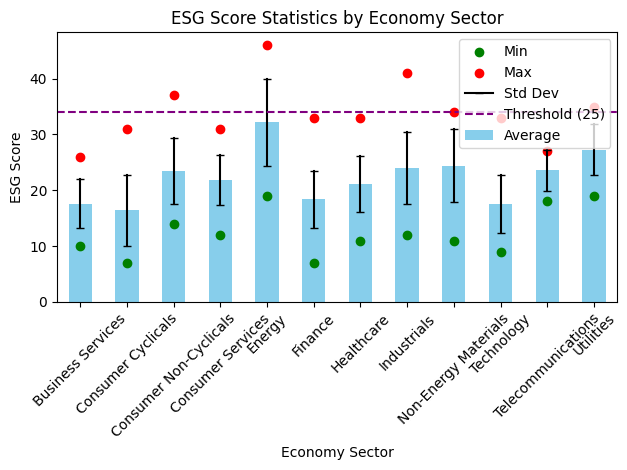

After using threshold for esg ratings (34), we are still left with 477 companies


In [8]:
threshold = 34
esgratings_df = ESG.get_esgdata(pd.read_csv( 'data/esg data.csv'), info_df)
ESG.plot_ESGscore_candlechart(esgratings_df, info_df, threshold)
filtered_esgcompanies = ESG.filter_esgratings(esgratings_df, threshold = threshold)
filtered_esgcompanies = filtered_esgcompanies.drop(['KVUE', "VLTO"])

In [9]:
forecastedVAR_df['IML'] = iml_factor
forecastedVAR_df_filtered = forecastedVAR_df[:'2023-11-20'][['Mkt-RF', 'HML', 'Momentum', 'IML']].dropna()

daily_logreturns_esg = daily_logreturns[daily_logreturns.columns[daily_logreturns.columns.isin(filtered_esgcompanies)]]
excess_returns = daily_logreturns_esg.iloc[1:] - rf_rate / days_in_year
excess_returns = excess_returns.loc[forecastedVAR_df_filtered.index]

df_params, df_signif = FF.regression_famafrench(excess_returns, forecastedVAR_df_filtered, factor_names=forecastedVAR_df_filtered.columns)
df_params = FF.run_famafrench(forecastedVAR_df_filtered, df_params, df_signif, factor_names=forecastedVAR_df_filtered.columns)
top_200_indices = FF.select_topcompanies_avgreturn(df_params, n_largest=200) 

In [10]:
df_params['avg_ret']

A      -0.001143
AAL     0.000190
AAPL    0.001911
ABBV    0.000190
ABNB   -0.000415
          ...   
YUM     0.000264
ZBH     0.000190
ZBRA    0.000498
ZION   -0.000286
ZTS     0.000372
Name: avg_ret, Length: 474, dtype: float64

In [11]:
selected_stocks_list = top_200_indices
selected_stocks_df = daily_logreturns[selected_stocks_list].dropna()
portfolio_returns = optimizer.run_optimizer(len(selected_stocks_list), selected_stocks_df)
df_stocks_with_weights = optimizer.calc_normalized_weights(np.array(portfolio_returns), selected_stocks_list)

In [13]:
df_stocks_with_weights

,Stock,Weight
0,NVDA,0.110742
1,META,0.149361
2,PHM,0.090749
4,LLY,0.220379
5,CPRT,0.044204
6,FICO,0.100010
27,RCL,0.059383
32,CMG,0.100429
36,PANW,0.052024
124,WELL,0.017556
